This walkthrough will demonstrate some potential approaches to using CAP bulk data via the publically whitelisted Illinois bulk dataset in XML format (1.4 GB compressed) https://capapi.org/bulk. All packages come standard with Anaconda, with the exception of the (optional) PyQuery parser.

In [1]:
import os
import sys
sys.path.append('..')

import lzma
import json
import xml.etree.cElementTree as ET

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')

import pyquery
from ipywidgets import FloatProgress
from IPython.display import display

from config import settings
import utils

%matplotlib inline

First get a dataset.

In [2]:
compressed_file = utils.get_and_extract_from_bulk(jurisdiction="Illinois", data_format="xml")

In [3]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open(compressed_file) as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Number of Cases: {}".format(len(cases)))

Number of Cases: 183149


That's a lot of files - the uncompressed Illinois dataset is more than 7 GB. If you'd like to decrease runtime, you can just sample 50,000 files for now. This function parses some basic information from the XML docs. Note that further information can be parsed from the XML files – this is just a sampling.

A note on parsers: the first (default) parser below is a very fast implementation in cElementTree, which some users may find difficult to modify. The second parser is a comparable implementation in PyQuery (credit to Jack Cushman https://github.com/jcushman), which is considerably easier to modify. cElementTree comes with most installations of Python, whereas PyQuery must be installed.

In [23]:
# ~10 minutes to parse all 183,149 files on a laptop    
def ET_parse_xml(case):
    feat_dict = {}
    header = True
    feat_dict["court"] = case['court']['name']
    feat_dict["jurisdiction"] = case['jurisdiction']['name_long']
    feat_dict["name"] = case['jurisdiction']['name']
    feat_dict["citation"] = [citation for citation in case['citations'] if citation['type'] == 'official'][0]
    feat_dict["date"] = case['decision_date']
    for elem in ET.fromstring(case['casebody']['data']):
        opinions = []
        if elem.tag.split("}")[1] == "opinion":
            op = {}
            text = []
            op["type"] = elem.attrib["type"]
            op["author"] = ""
            for opinion_element in elem.getchildren():
                if opinion_element.tag.split("}")[1] == 'author':
                    op["author"] = opinion_element.text.replace(u'\xad', '')
                else:
                    text.append(opinion_element.text.replace(u'\xad', ''))
            op["text"] = " ".join(text)
            opinions.append(op)
    feat_dict["opinions"] = opinions
    return feat_dict

ET_parse_xml(cases[0])

{'citation': {'cite': '2 Ill. App. 3d 538', 'type': 'official'},
 'court': 'Illinois Appellate Court',
 'date': '1771-10-12',
 'jurisdiction': 'Illinois',
 'name': 'Ill.',
 'opinions': [{'author': 'Mr. PRESIDING JUSTICE EBERSPACHER',
   'text': 'delivered the opinion of the court: Defendant Tobin was convicted by a jury of the crime of burglary. The court entered judgment upon the verdict and sentenced the defendant to a fifteen to twenty-five year term in the Illinois State Penitentiary. The judgment of the court further provided that the mittimus was to be effective upon release by federal authorities. The defendant has appealed from that judgment and raised the following issues: (1) The State failed to prove lack of authority to enter the premises; (2) The State failed to prove intent to commit a theft; (3) The court erred in allowing testimony concerning the arrest of Sherri Tobin, her possession of a firearm and evidence concerning defendant’s possession of a firearm; (4) The sent

In [24]:
# ~13 minutes to parse all 183,149 files on a laptop
# SKIP if you want to use the default parser
from pyquery import PyQuery

nsmap = {
    'case': 'http://nrs.harvard.edu/urn-3:HLS.Libr.US_Case_Law.Schema.Case:v1',
    'casebody': 'http://nrs.harvard.edu/urn-3:HLS.Libr.US_Case_Law.Schema.Case_Body:v1',
}

def pyq_parse_xml(filename):
    parsed = PyQuery(filename=filename, parser='xml', namespaces=nsmap)
    court = parsed('case|court')
    return {
        'court': court.text(),
        'jurisdiction': court.attr('jurisdiction'),
        'name': parsed('case|name').text().replace(u'\xad', ''),
        'citation': parsed('case|citation').eq(0).text(),
        'date': parsed('case|decisiondate').text(),
        'opinions': [
            {
                'type': opinion.attr('type'),
                'author': opinion('author').text().replace(u'\xad', ''),
                'text': opinion.text(),
            }
            for opinion in parsed('casebody|opinion').items()
        ]
    }

In [25]:
#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = ET_parse_xml(case) #If you would like to use the PyQuery parser, change the function name here!
    parsed_files.append(doc)
    bar.value += 1

#You may want to dump the files to a JSON document here, or pickle the dataframe after generating it

FloatProgress(value=0.0, max=183149.0)

Let's load these parsed files into pandas for ease of manipulation...

In [26]:
raw_df = pd.DataFrame(parsed_files)
#Parse dates
raw_df["date"] = pd.to_datetime(raw_df["date"])
#Strip out some sparse early data
df = raw_df[raw_df["date"] >= '1850-01-01']
df.head()

,citation,court,date,jurisdiction,name,opinions
1378,"{'cite': '11 Ill. 646', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,"[{'text': 'This was an action of covenant, bro..."
1379,"{'cite': '11 Ill. 467', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,[{'text': 'The principal question in this case...
1380,"{'cite': '11 Ill. 592', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,[{'text': 'The seventh and eighth sections of ...
1381,"{'cite': '11 Ill. 597', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,[{'text': 'This case originated before a justi...
1382,"{'cite': '11 Ill. 650', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,[{'text': 'The eleventh section of the “ Act s...


So we've got a host of useful information here, including jurisdiction, court, case name, citation, date, and, of course, the case text broken down by opinion. Let's ask a question: on a case insensitive basis, how does n-gram frequency reflect the emergence of new technologies?

In [27]:
#Takes a dataframe of cases and an n-gram and returns a list of (year, n-gram count) tuples
def get_ngram_count(cases, ngram):
    
    #Build a dictionary of all years present in the dataframe
    result = {year:0 for year in cases["date"].apply(lambda x: x.year).unique()}
    #Across all cases...
    for _, case in cases.iterrows():
        mentions = 0
        for opinion in case['opinions']:
            #...count all cases containing n-gram using dictionary entries
            if (ngram in opinion['text'].lower()):
                result[int(case['date'].year)] += 1
                break
    #Return a sorted list of the tuples
    return sorted(list(result.items()), key=lambda x:x[0])

#Visualize an ngram using matplotlib, passing in an axis
def visualize_ngram(title, ax, ngram_data):
    #Get counts of each year across case decision dates (we use to this to calculate proportion of cases with n-gram)
    year_counts = df["date"].apply(lambda x:x.year).value_counts().sort_index().values
    ax.set_xlim(1850,2020)
    ax.set_title("'{}' occurs in {} cases".format(title, sum(x[1] for x in ngram_data)))
    ax.set_ylabel("Proportion of cases with ngram")
    ax.set_xlabel("Year Decided")
    #Years on the x-axis, n-gram counts on the y axis
    ax.plot([x[0] for x in ngram_data], [x[1] for x in ngram_data]/year_counts)

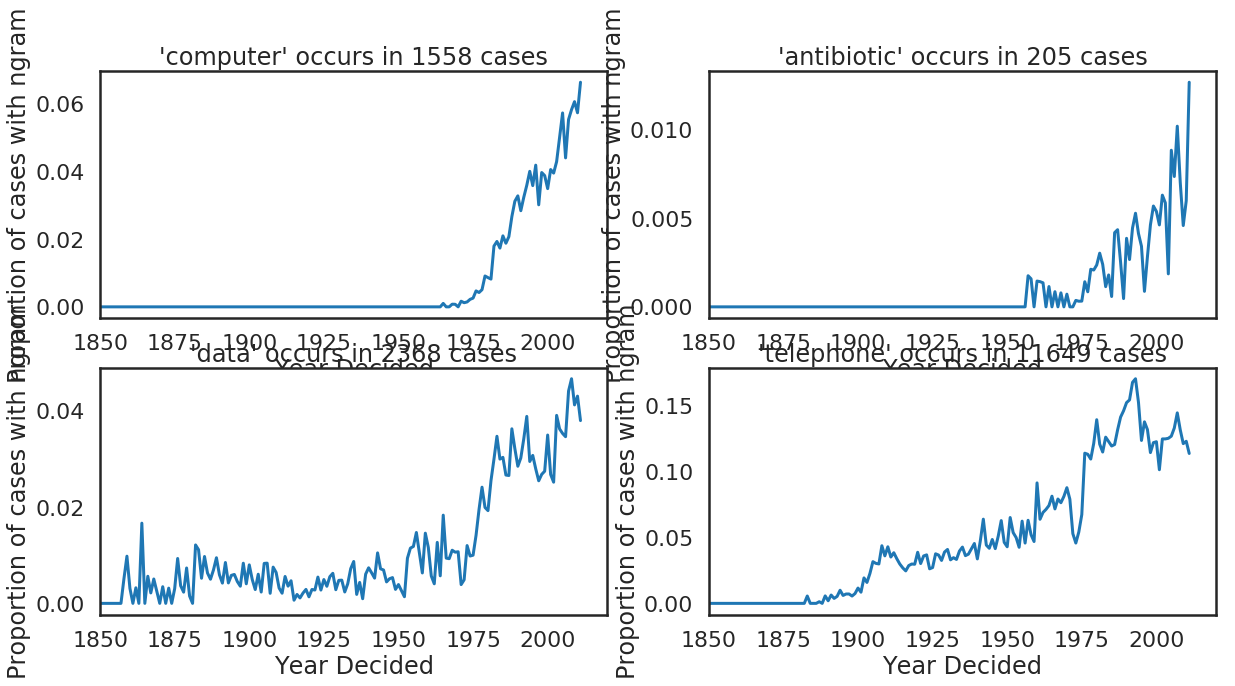

In [28]:
#NOTE: This code takes quite a while to run
#Generate subplots
fig, axes = plt.subplots(2, 2, figsize=(20,10))

#generate visualizations for n-grams, passing a matplotlib axis for each
visualize_ngram("computer", axes[0,0], get_ngram_count(df, "computer"))
visualize_ngram("antibiotic", axes[0,1], get_ngram_count(df, "antibiotic"))
visualize_ngram("data", axes[1,0], get_ngram_count(df, " data "))
visualize_ngram("telephone", axes[1,1], get_ngram_count(df, "telephone"))

Next, let's look at the average length of cases varies between Illinois courts.

In [29]:
#Let's look at how many cases fall in each court
df['court'].value_counts(normalize=False)

Illinois Appellate Court                                              123911
Illinois Supreme Court                                                 47804
Illinois Court of Claims                                                9848
Illinois Circuit Court                                                   201
United States District Court for the Northern District of Illinois         3
Illinois Appellate Court`                                                  1
Illinois Appellate Court.                                                  1
Illinois Appellate Court Reports                                           1
i                                                                          1
Name: court, dtype: int64

In [30]:
#Let's trim to just the 4 non-broken court types
df = df[df['court'].isin(df['court'].value_counts()[:4].index.tolist())]

In [31]:
#Let's get the average length of a case in words for each court
court_lengths = []

#Build a list of tuples indicating average lengths for each court
for court in df["court"].unique():
    num = df[df["court"] == court].shape[0]
    lens = sum(df[df["court"] == court]["opinions"].apply(lambda x: sum([len(op["text"].split(" ")) for op in x])))
    court_lengths.append((court, lens/num))

#Sort by average length
court_lengths = sorted(court_lengths, key=lambda x: x[1])
court_lengths

[('Illinois Court of Claims', 592.9401909017059),
 ('Illinois Appellate Court', 1717.404604918046),
 ('Illinois Supreme Court', 1789.0317755836331),
 ('Illinois Circuit Court', 2393.2985074626868)]

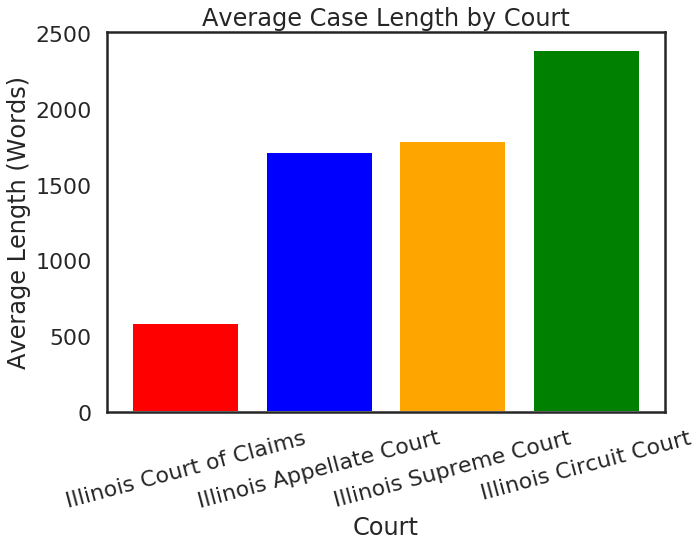

In [32]:
#Build a dictionary of court:color mappings for consistency across graphs
court_color_dict = {
    'Illinois Court of Claims': 'red',
    'Illinois Appellate Court': 'blue',
    'Illinois Supreme Court' : 'orange',
    'Illinois Circuit Court': 'green'
}

#Display bar plot of lengths
plt.figure(figsize=(10,7))
for i, court in enumerate(court_lengths):
    plt.bar(i, court[1], color=court_color_dict[court[0]])

plt.title("Average Case Length by Court")
plt.xlabel("Court")
plt.ylabel("Average Length (Words)")
plt.xticks(list(range(0,len(court_lengths))), [x[0] for x in court_lengths])
locations, labels = plt.xticks()
plt.setp(labels, rotation=15)

plt.show()

In [33]:
#Let's get the average length of a case in words for each court over time
court_lengths_chron = {}

#Get a list of dates in 2 year intervals from 1850-2012
drange = pd.date_range('1850-01-01', '2012-01-01', freq='2Y')

#For each court...
for court in df["court"].unique():
    #Add key for court in dictionary, and associate with a new list.
    #This list will hold average lengths for each span in our date range
    court_lengths_chron[court] = []
    for span in drange:
        end_span = span.replace(year = span.year + 2)
        #Filter to span
        df_temp = df[(df["court"] == court) & (df["date"] >= span) & (df["date"] < end_span)]
        num = df_temp.shape[0]
        #Get total words for court cases in span
        lens = sum(df_temp["opinions"].apply(lambda x: sum([len(op["text"].split(" ")) for op in x])))
        #Add average or None to list
        if num > 0:
            court_lengths_chron[court].append(lens/num)
        else:
            court_lengths_chron[court].append(None)

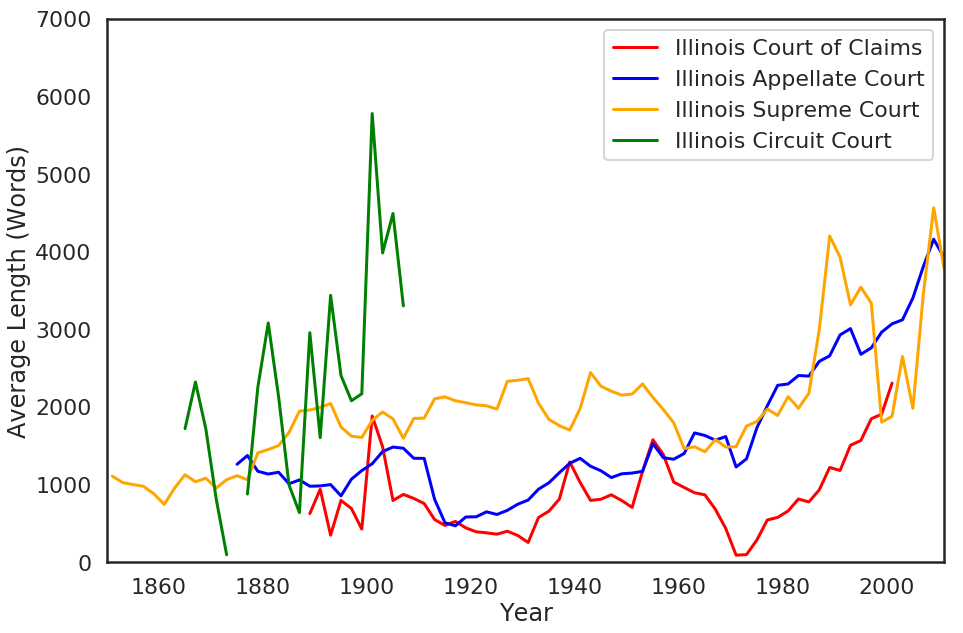

In [34]:
#Graph average lengths over time for each court
plt.figure(figsize=(15,10))
for court in court_lengths_chron.keys():
    plt.plot(drange, court_lengths_chron[court], label=court, color=court_color_dict[court])
    
plt.legend()
plt.xlim('1850-01-01','2011-01-01')
plt.xlabel("Year")
plt.ylabel("Average Length (Words)")
plt.ylim(0,7000)
plt.show()

There are times where we would prefer to analyze case data primarily on the opinion level rather than the case level. Let's reshape our dataframe to contain a row for each individual opinion.

In [35]:
array_opinions = []

#Loop thorugh case dataframe and flatten opinions
for _, row in df.iterrows():
    for opinion in row["opinions"]:
        temp = {}
        keys = list(row.keys())
        keys.remove('opinions')
        for key in keys:         
            temp[key] = row[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        array_opinions.append(temp)

df_opinions = pd.DataFrame(array_opinions)
df_opinions.head(3)

,author,citation,court,date,jurisdiction,name,text,type
0,"Opinion by Treat, C. J.;","{'cite': '11 Ill. 646', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,"This was an action of covenant, brought by Hun...",majority
1,"Opinion by Treat, C. J.:","{'cite': '11 Ill. 467', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,"The principal question in this case is, whethe...",majority
2,"Opinion by Treat, C. J.:","{'cite': '11 Ill. 592', 'type': 'official'}",Illinois Supreme Court,1850-06-01,Illinois,Ill.,The seventh and eighth sections of “An act to ...,majority


For example, let's say we want to generate a list of the most prolific judges in our dataset...

In [36]:
most_prolific = df_opinions["author"].value_counts()
#This gets around bugs related to .lower() in some versions of pandas
most_prolific = most_prolific[~most_prolific.index.str.contains('uriam')]
most_prolific = most_prolific[~most_prolific.index.str.contains('CURIAM')]
most_prolific = most_prolific.drop("")
most_prolific.head()

Mr. Justice Cartwright    1559
Mr. Justice Carter        1333
Mr. Justice Craig         1296
Mr. Justice Dunn          1219
Mr. Justice Stone         1147
Name: author, dtype: int64

Let's generate a dictionary of all Illinois judges who have written opinions so that we can analyze patterns in written output over time. Each entry in the dictionary will be a subdictionary of years, with entries indicating how many opinions the judge authored in the corresponding year.

In [37]:
authors = {}
for _, opinion in df_opinions.iterrows():
    if opinion["author"] and "curiam" not in opinion["author"]:
        author = opinion["author"]
        year = opinion["date"].year
        if "curiam" in author.lower():
            author = 'Per Curiam.'
        #add to dictionary of authors with subdictionary of years for each author
        if author in authors:
            if year in authors[author]:
                authors[author][year] += 1
            else:
                authors[author][year] = 1
        else:
            authors[author] = {}
            authors[author][year] = 1

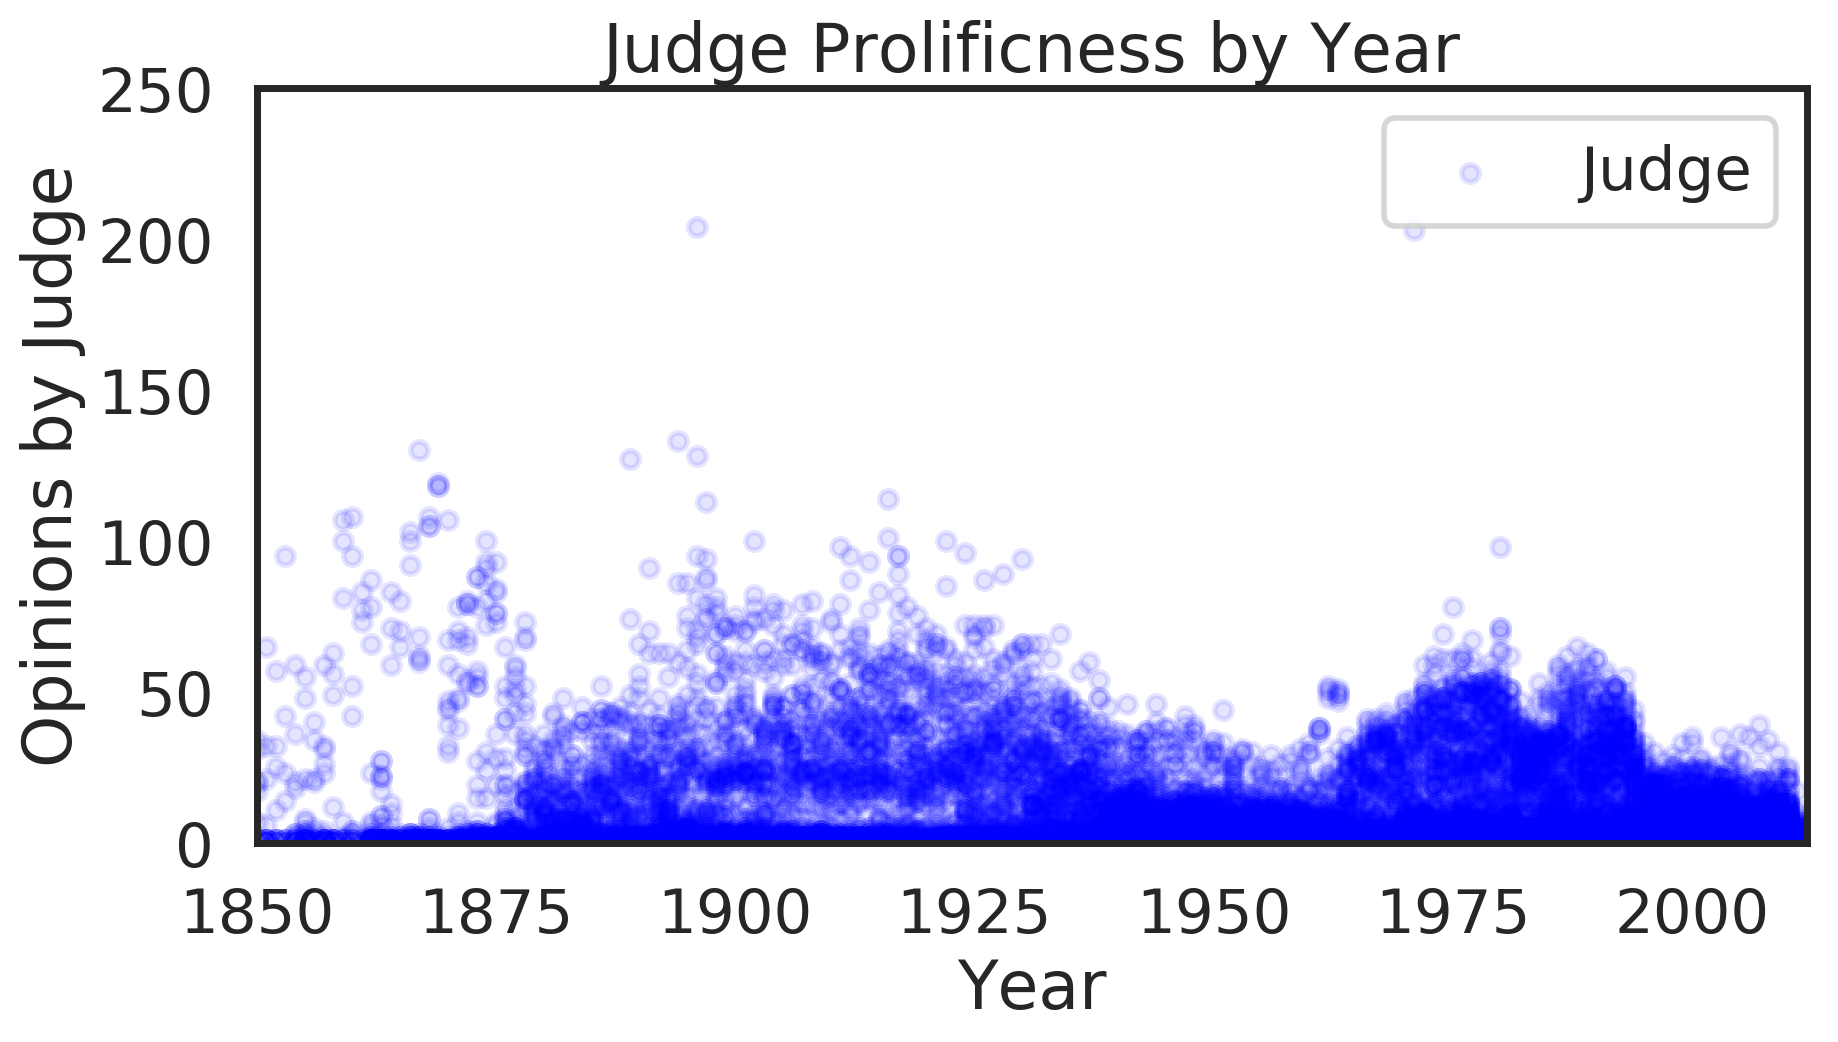

In [38]:
plt.figure(figsize=(10,5), dpi=200)
plt.ylim(0, 250)
plt.xlim(1850, 2012)

#build lists of year/opinion count coordinates across all justices
x, y = [], []
for justice in most_prolific.index.tolist():
    temp_x,temp_y = zip(*authors[justice].items())
    x.extend(temp_x)
    y.extend(temp_y)

plt.title("Judge Prolificness by Year")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.scatter(x,y, color='blue', alpha=0.1, s=40, label='Judge')
#c_x,c_y = zip(*authors["Mr. Justice Cartwright"].items())
#plt.scatter(c_x,c_y, alpha=0.5, s=40, label="Cartwright", color="red")

plt.legend(frameon=True)
plt.savefig("prolificness1.png")
plt.show()

Interesting – it seems that today's judges tend to write fewer opinions per year than their predecessors – look at what the judges of the late 19th and early 20th century were doing! Next, let's look at the 10 most prolific judges in our (uncleaned) dataset.

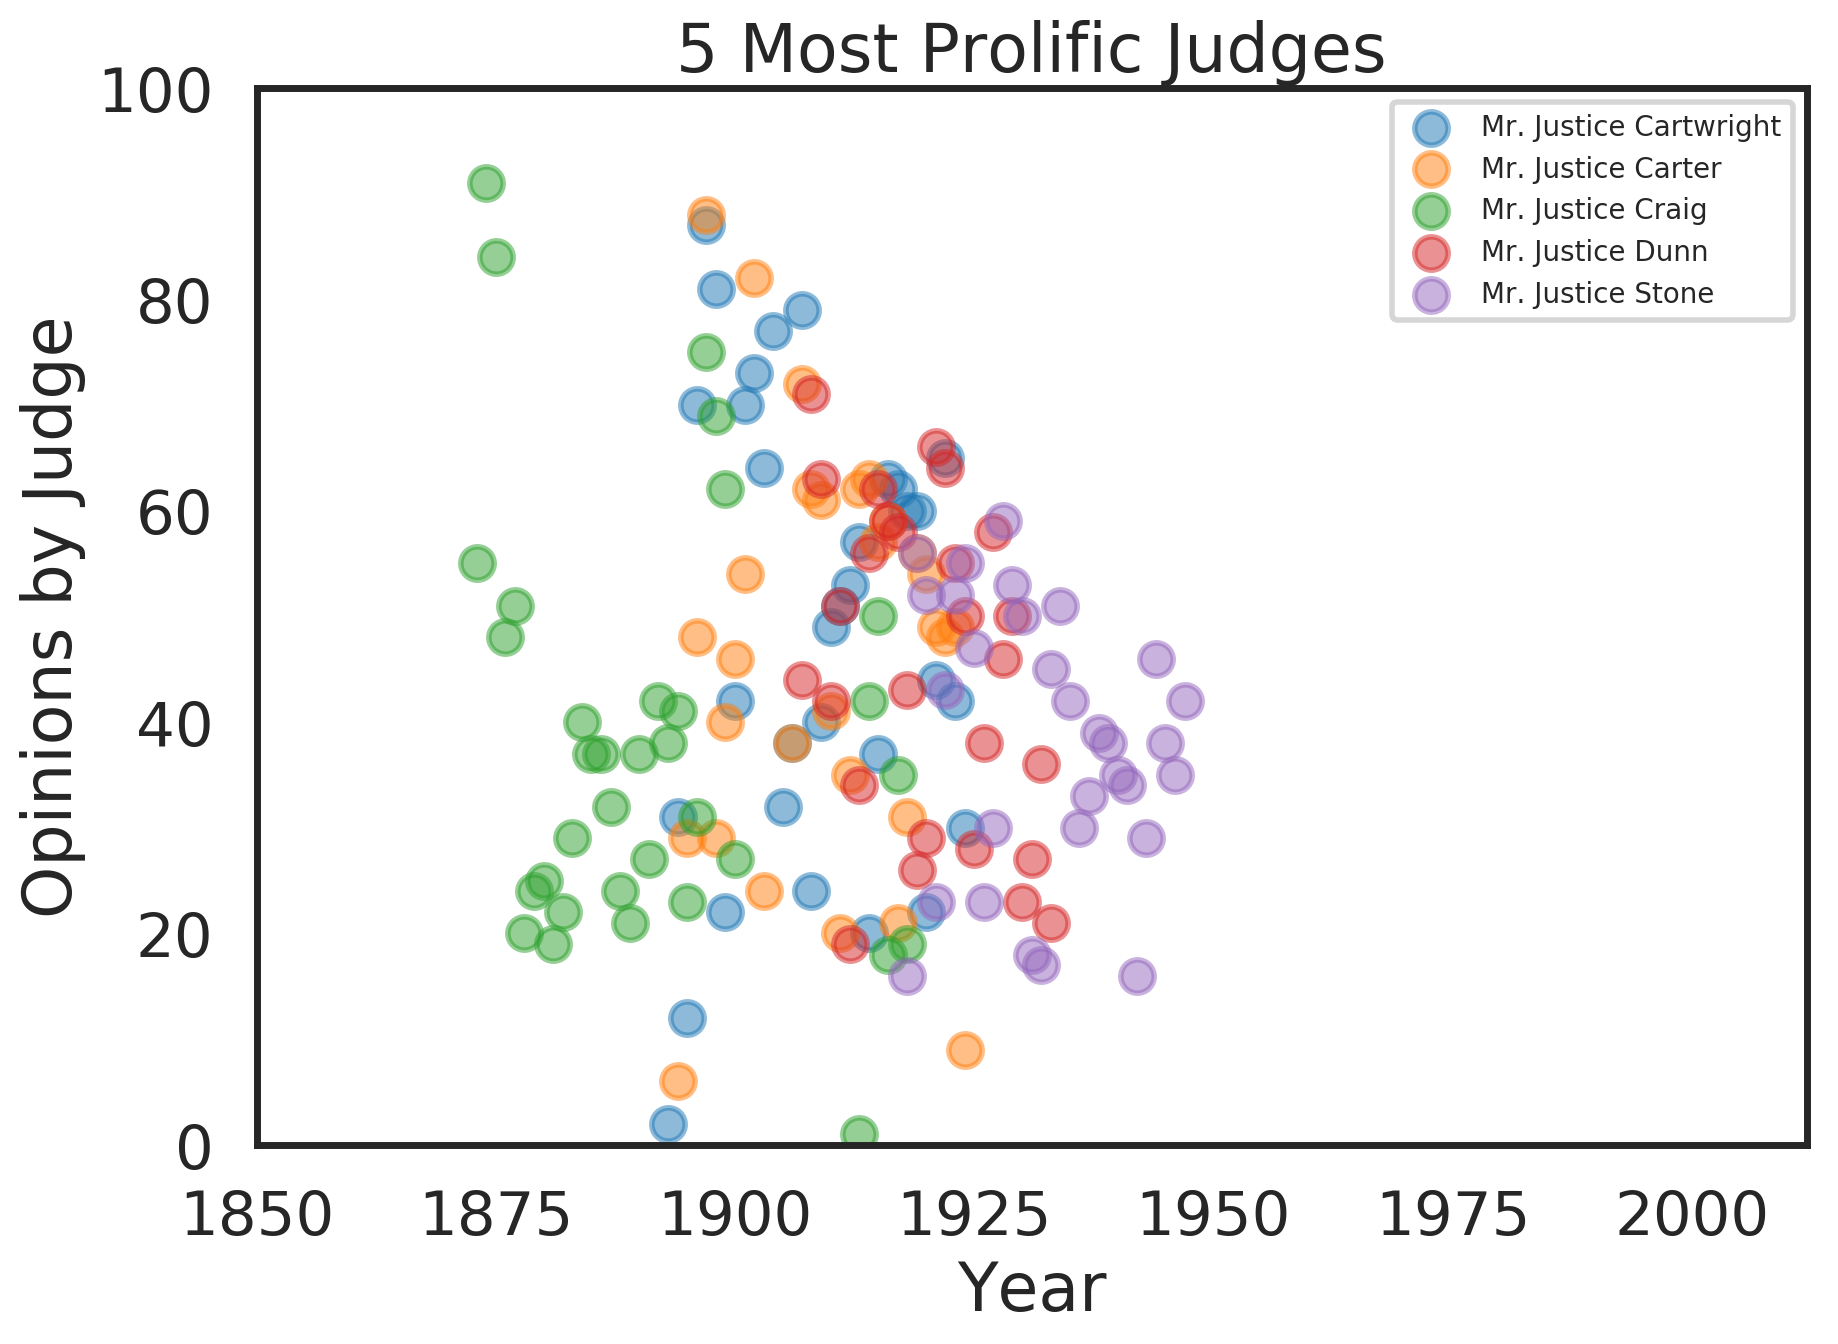

In [39]:
plt.figure(figsize=(10, 7), dpi=200)
plt.ylim(0, 100)
plt.xlim(1850, 2012)

#Get year/opinion count figures for top 10 judges
for justice in most_prolific.index.tolist()[:5]:
    x,y = zip(*authors[justice].items())
    plt.scatter(x,y, alpha=0.5, label=justice)


plt.title("5 Most Prolific Judges")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(fontsize=10)
plt.savefig("prolificness2.png")
plt.show()

Interesting – all of these judges worked in the first half of the 20th century or earlier. It looks like most of these prolific opinion writers are Supreme Court justices. Let's look at Mr. Justice Cartwright, our most prolific judge. Cartwright served on the Illinois Supreme Court from 1895 to 1924.

In [40]:
#Filter the dataframe down to entries mentioning Cartwright
cartwright = df_opinions[(df_opinions["author"].str.contains('Cartwright')) & \
                         (df_opinions["date"] >= '01-01-1895') &              \
                         (df_opinions["date"] < '05-18-1924')]
#Sort by date
cartwright = cartwright.sort_values('date').reset_index(drop=True)
#Let's see how Cartwright is listed as an author
cartwright["author"].value_counts()[:15]

Mr. Justice Cartwright               1526
Mr. Chief Justice Cartwright          278
Mr. Presiding Justice Cartwright       27
Mr. Chiee Justice Cartwright           14
Mr. Justice Cartwright,                13
Mr. Justice; Cartwright                 9
Dunn and Cartwright, JJ.,               7
Mr. Chibe Justice Cartwright            6
Cartwright and Hand, JJ.,               6
Mr. Justicr Cartwright                  6
Hand and Cartwright, JJ.,               5
Mr. ChiEE Justice Cartwright            4
Mr. Chile Justice Cartwright            4
Mr. Chief Justice Cartwright,           4
Cartwright, Carter and Dunn, JJ.,       3
Name: author, dtype: int64

As always with OCR data, there are some issues here. It would take a lot of manual cleaning to get it perfect, so let's just fix some of the more common OCR errors

In [41]:
#Clean cartwright's entries up a little bit
aliases_justice = ["Cartwright, J.", "Mr. Justice Cartwright,", "Mr. Justice; Cartwright", 
                   "Mr. Justicr Cartwright", "Mr. JusTicp Cartwright"]
cartwright = cartwright.replace(aliases_justice, "Mr. Justice Cartwright")

aliases_chief_justice = ["Mr. Chiee Justice Cartwright", "Mr. Chief Justice Cartwright,",
                        "Mr. Chibe Justice Cartwright", "Mr. ChiEE Justice Cartwright",
                        "Mr. Chile Justice Cartwright"]
cartwright = cartwright.replace(aliases_chief_justice, "Mr. Justice Cartwright")

Let's find out a little bit more about Cartwright – how many dissents and majority opinions did he write, and what cases did he dissent on? What were the titles of the cases he entered opinions on in 1924-04-14 (his last opinions before his death)?

In [42]:
cartwright['type'].value_counts()

majority       1929
dissent         112
concurrence      11
rehearing         1
Name: type, dtype: int64

In [43]:
cartwright[cartwright['type'] == 'dissent'].head(5)

,author,citation,court,date,jurisdiction,name,text,type
264,"Craig, Wilkin and Cartwright, JJ.,","{'cite': '175 Ill. 125', 'type': 'official'}",Illinois Supreme Court,1898-10-24,Illinois,Ill.,dissenting: We do not concur in the foregoing ...,dissent
268,Mr. Justice Cartwright,"{'cite': '176 Ill. 471', 'type': 'official'}",Illinois Supreme Court,1898-10-24,Illinois,Ill.,dissenting: I cannot agree to the rule stated ...,dissent
269,"Phillips and Cartwright, JJ.,","{'cite': '177 Ill. 525', 'type': 'official'}",Illinois Supreme Court,1898-12-21,Illinois,Ill.,dissenting: We do not concur in giving to the ...,dissent
303,"Cartwright and Craig, JJ.:","{'cite': '179 Ill. 62', 'type': 'official'}",Illinois Supreme Court,1899-04-17,Illinois,Ill.,We dissent from so much of the foregoing opini...,dissent
324,Mr. Justice Cartwright,"{'cite': '181 Ill. 289', 'type': 'official'}",Illinois Supreme Court,1899-10-16,Illinois,Ill.,dissenting: The occupation of a street as a pl...,dissent


In [44]:
cartwright[cartwright['date'] == '1924-04-14']['name'].tolist()

['Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.',
 'Ill.']

This is interesting, and there's much more we could learn about Cartwright from the case data. However, let's broaden our analysis a little bit to contextualize Cartwright's work within that of the Illinois Supreme Court during his tenure.

In [45]:
#Filter opinions dataframe to include only opinions of the Illinois Supreme Court 1895-1925
peers_df = df_opinions[(df_opinions["date"] >= '01-01-1895') & \
                       (df_opinions["date"] < '1-1-1925') & \
                       (df_opinions["court"] == "Illinois Supreme Court")]
peers_df.head()

,author,citation,court,date,jurisdiction,name,text,type
23461,Mr. Justice Magruder,"{'cite': '155 Ill. 579', 'type': 'official'}",Illinois Supreme Court,1895-01-11,Illinois,Ill.,delivered the opinion of the court:• This is a...,majority
23463,Mr. Justice Baker,"{'cite': '155 Ill. 566', 'type': 'official'}",Illinois Supreme Court,1895-01-12,Illinois,Ill.,delivered the opinion of the court: The trial ...,majority
23464,Mr. Justice Magruder,"{'cite': '156 Ill. 113', 'type': 'official'}",Illinois Supreme Court,1895-01-12,Illinois,Ill.,delivered the opinion of the court: This is a ...,majority
23465,"Baker, J.:","{'cite': '154 Ill. 595', 'type': 'official'}",Illinois Supreme Court,1895-01-14,Illinois,Ill.,Merton Dunlap was county clerk of Ford county ...,majority
23466,"Baker, J.:","{'cite': '154 Ill. 656', 'type': 'official'}",Illinois Supreme Court,1895-01-14,Illinois,Ill.,This was a proceeding brought by the town of C...,majority


Let's look at some of the most prolific judges over this 30 year period in the court's history (and clean up our opinions' "author" fields, if possible)

In [46]:
peers_df["author"].value_counts()[:50]

Mr. Justice Cartwright                 1514
Mr. Justice Carter                     1327
Mr. Justice Dunn                        892
Mr. Justice Farmer                      835
Mr. Justice Wilkin                      715
Mr. Justice Hand                        621
Mr. Justice Magruder                    539
Mr. Justice Boggs                       534
Mr. Justice Craig                       452
Mr. Justice Vickers                     409
Mr. Justice Cooke                       397
Per Curiam:                             385
Mr. Justice Duncan                      373
Mr. Justice Scott                       329
Mr. Justice Phillips                    309
Mr. Justice Stone                       297
Mr. Justice Thompson                    280
Mr. Chief Justice Cartwright            278
Per Curiam :                            242
Mr. Justice Ricks                       225
Mr. Chief Justice Carter                134
Mr. Chief Justice Hand                  133
Mr. Justice Baker               

While a lot of these look pretty good, there are a few major problems that we should solve before we start comparing justices.

- Chief Justice and Associate Justice opinions are listed separately for each justice (the Chief Justice of the Illinois Supreme Court is reelected every three years from among the justices), and should be consolidated.
- There are some clear OCR errors and inconsistencies that should be standardized (trailing commas and "Chiee" Justices, for instance). NOTE: ~2% of entries in this dataframe still contain less common OCR errors.
- Per Curiam opinions are showing up in a range of OCR formats.

In [47]:
#Implement an (incomplete) range of 
def clean_authors(author):
    a = author
    aliases_justice = ["Mr. Chiee Justice", "Mr. Chief Justice",
                        "Mr. Chibe Justice", "Mr. ChiEE Justice",
                        "Mr. Chile Justice", "Mr. Chiep Justice",
                        "Mr. Ciiiep Justice"]
    for alias in aliases_justice:
        a = a.replace(alias, "Mr. Justice")
        
    a = a.replace("Chief ", "").replace(",", "").replace("'", "").replace(":", "").replace(";", "")
    a = a.replace("-", "").replace("Chiee ", "").replace("delivered", "").strip()    
    a = a.replace("Parmer", "Farmer").replace("Earmer", "Farmer").replace("Vicicers", "Vickers")
    a = a.replace("Garter", "Carter").replace("Ricics", "Ricks").replace("Eicks", "Ricks")
    a = a.replace("Cooice", "Cooke").replace("Cartwrigi-it", "Cartwright").replace("CooicE", "Cooke")
    a = a.replace("Mr ", "Mr.").replace("Mr.J", "Mr. J").replace("Wilicin", "Wilkin").replace("Wieicin", "Wilkin")
    a = a.replace("Macruder", "Magruder").replace("Cartwrigiit", "Cartwright")
    a = a.replace("Phillips J.", "Mr. Justice Phillips")
    a = a.replace("Craig J.", "Mr. Justice Craig")
    a = a.replace("Baker J.", "Mr. Justice Baker")
    a = a.replace("Magruder J.", "Mr. Justice Magruder").replace("MagrudER", "Magruder").replace("MagrudEr", "Magruder")
    a = a.replace("Justicr", "Justice").replace("J ustice", "Justice"). replace("JUSTICE", "Justice")
    a = a.strip()
    return a
    
peers_df["author"] = peers_df["author"].apply(clean_authors)
peers_df = peers_df.drop(peers_df[peers_df["author"] == "Mr. Justice"].index)
peers_df = peers_df.drop(peers_df[peers_df["author"] == "Per Curiam"].index)
peers_df = peers_df.drop(peers_df[peers_df["author"] == ""].index)
peers_df.loc[(peers_df["date"] > '1913-01-01') & (peers_df["author"] == "Mr. Justice Craig"), "author"] = "Mr. Justice Charles Craig"
peers_df.loc[(peers_df["date"] < '1913-01-01') & (peers_df["author"] == "Mr. Justice Craig"), "author"] = "Mr. Justice Alfred Craig"
peers_df.loc[(peers_df["date"] > '1903-01-01') & (peers_df["author"] == "Mr. Justice Carter"), "author"] = "Mr. Justice Orrin Carter"
peers_df.loc[(peers_df["date"] < '1903-01-01') & (peers_df["author"] == "Mr. Justice Carter"), "author"] = "Mr. Justice Joseph Carter"


#The top 22 entries are real justices – value chosen by examination
justices = peers_df["author"].value_counts()[:22].keys().tolist()
peers_df["author"].value_counts()[:22]

/Users/aaizman/.pyenv/versions/3.5.4/envs/capexamples/lib/python3.5/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Mr. Justice Cartwright       1884
Mr. Justice Orrin Carter     1084
Mr. Justice Farmer           1041
Mr. Justice Dunn             1018
Mr. Justice Wilkin            834
Mr. Justice Hand              778
Mr. Justice Magruder          722
Mr. Justice Boggs             597
Mr. Justice Joseph Carter     494
Mr. Justice Cooke             491
Mr. Justice Vickers           483
Mr. Justice Duncan            466
Mr. Justice Scott             396
Mr. Justice Phillips          393
Mr. Justice Thompson          376
Mr. Justice Stone             348
Mr. Justice Alfred Craig      341
Mr. Justice Ricks             306
Mr. Justice Charles Craig     235
Mr. Justice Baker             147
Mr. Justice Heard              35
Mr. Justice Bailey             35
Name: author, dtype: int64

That looks a good bit better. Notice that OCR errors and standardization can have a huge impact on the accuracy of statistics extracted from CAP datasets – be sure to clean carefully. 

Let's ignore the jointly written opinions for now and start comparing our justices. To start, let's take a look at the number of opinions written by each justice on a year by year basis: 

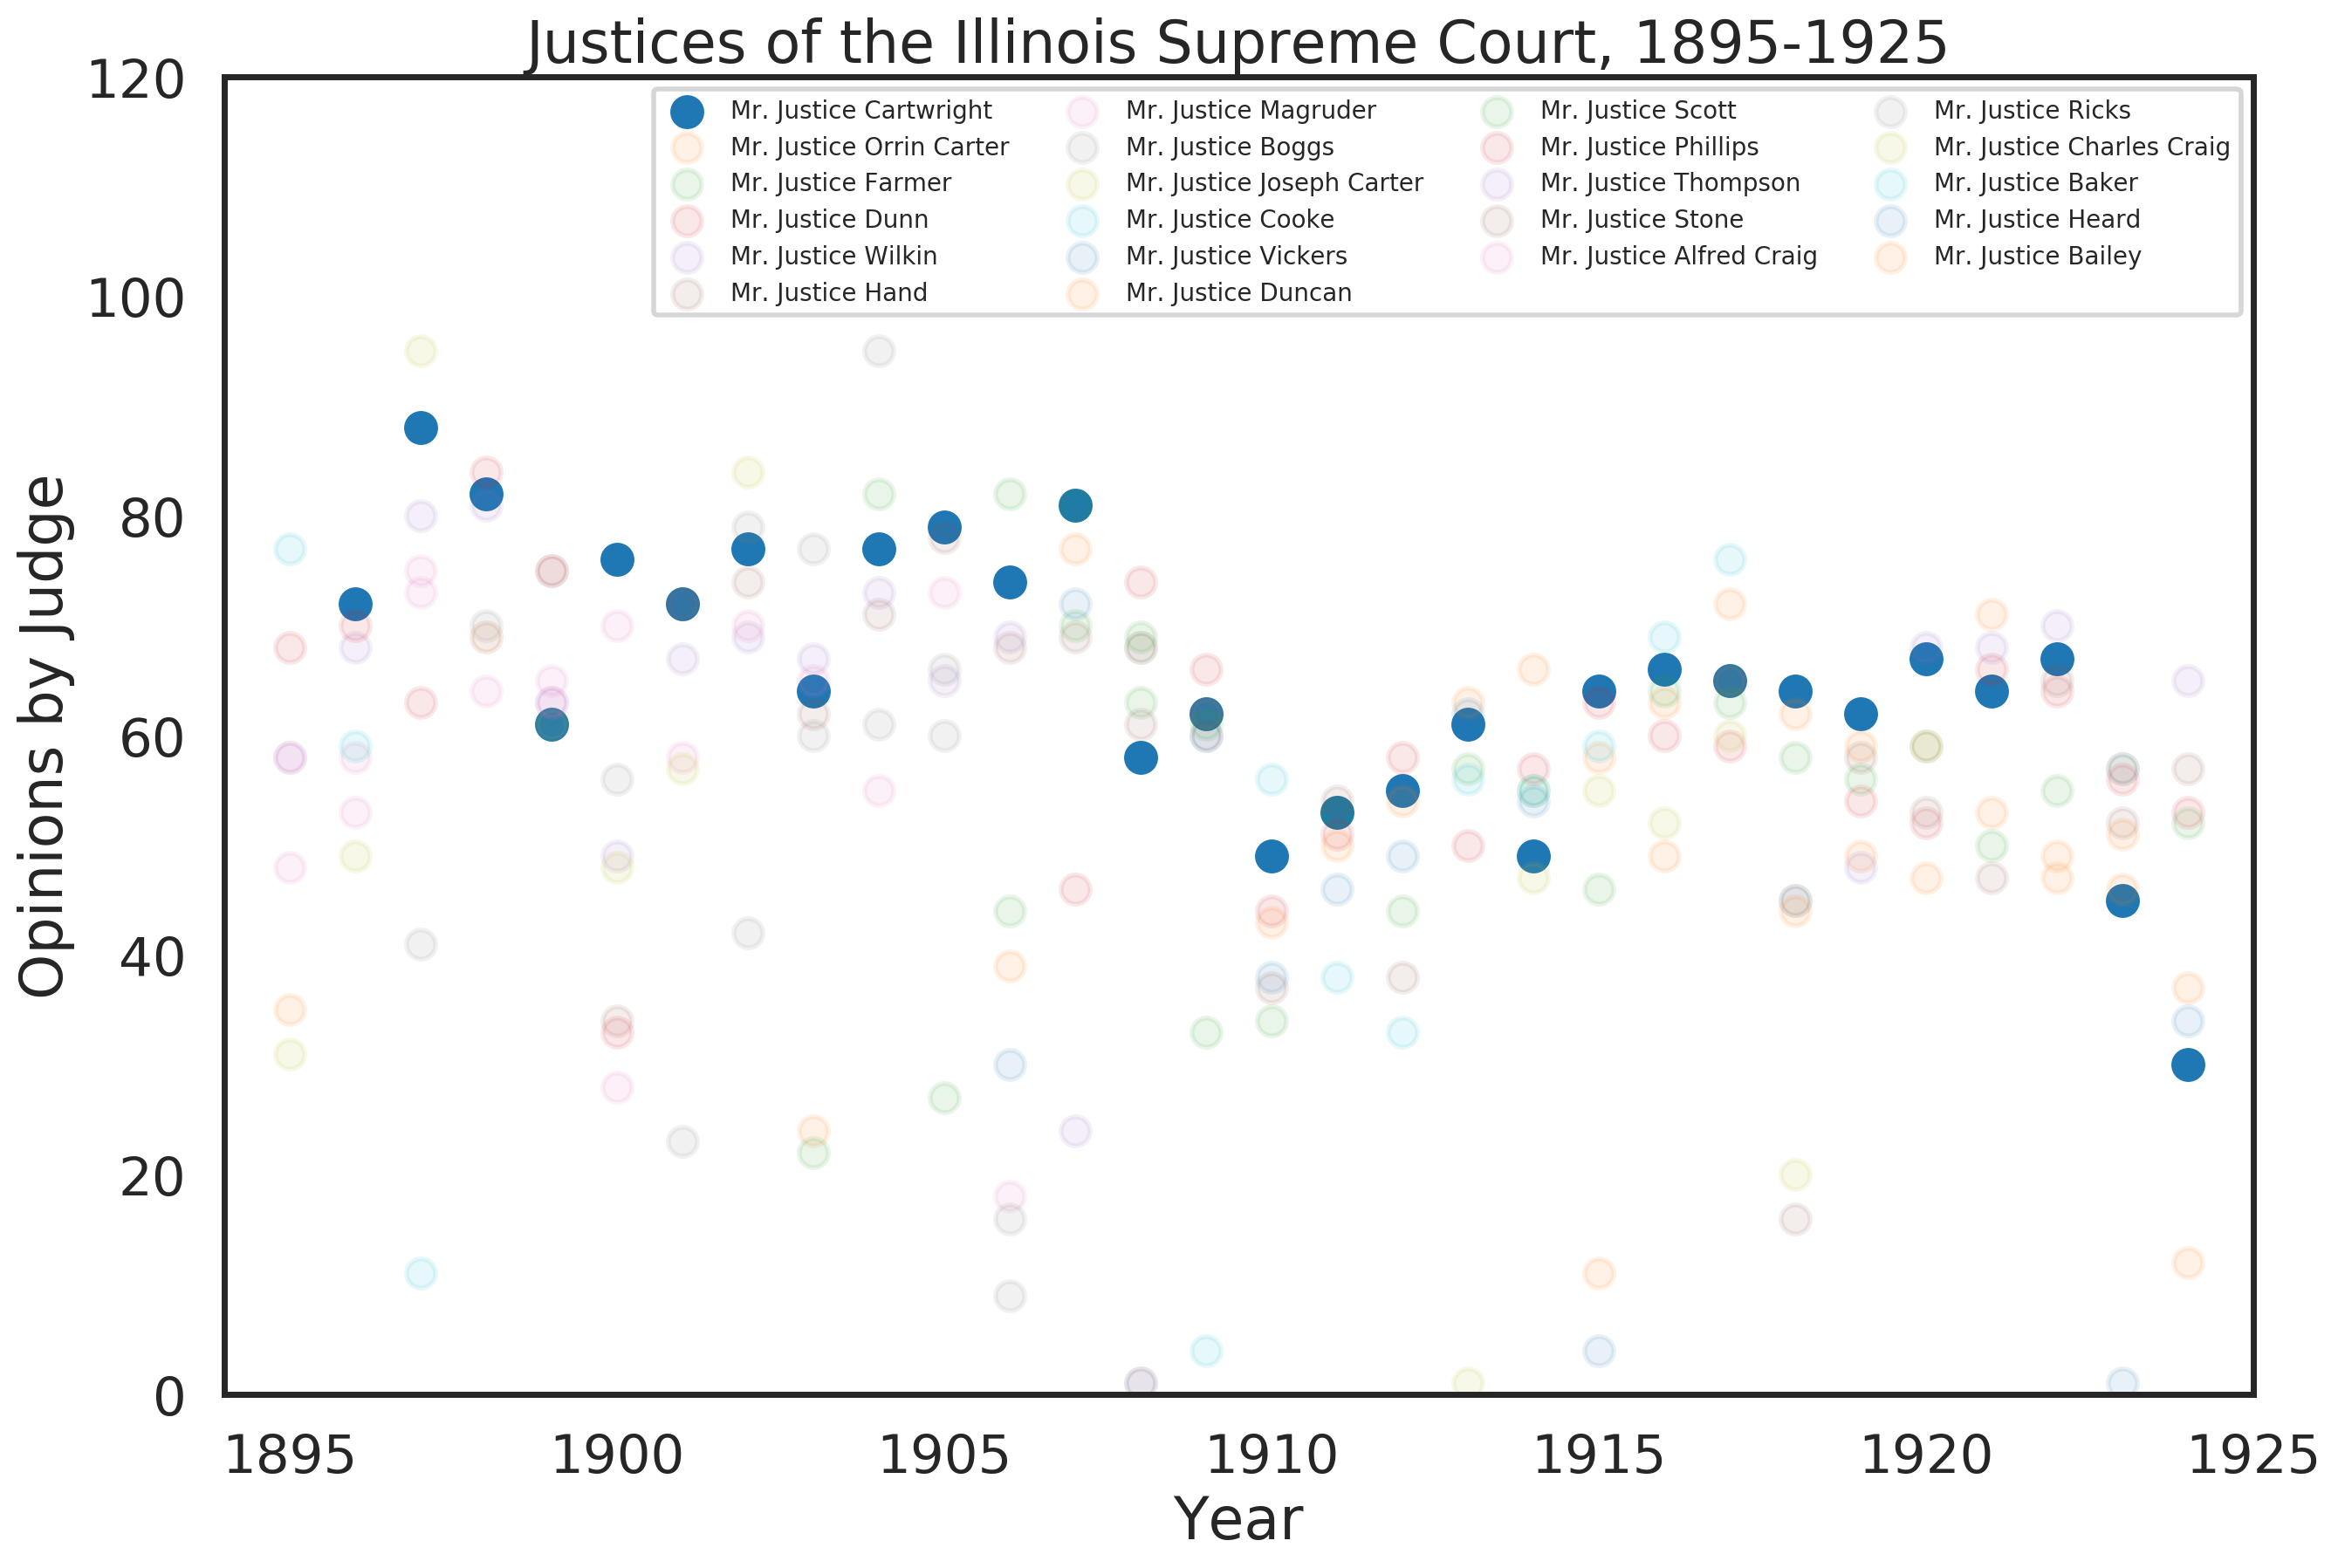

In [48]:
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 120)
plt.xlim(1894, 1925)

#Get year/opinion count figures for each justice in the set
for justice in justices:
    items = peers_df[peers_df["author"] == justice]["date"].apply(lambda x:x.year).value_counts().items()
    x,y = zip(*items)
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.1
    plt.scatter(x,y, alpha=alp, label=justice)


plt.title("Justices of the Illinois Supreme Court, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(ncol=4, fontsize=10)
plt.savefig("cartwright1.png")
plt.show()

Cartwright consistently has the highest or near-highest output of opinions throughout his 30-year career (with the exception of the 2 years leading up to his death). Impressive! Let's learn more about his case writing patterns...

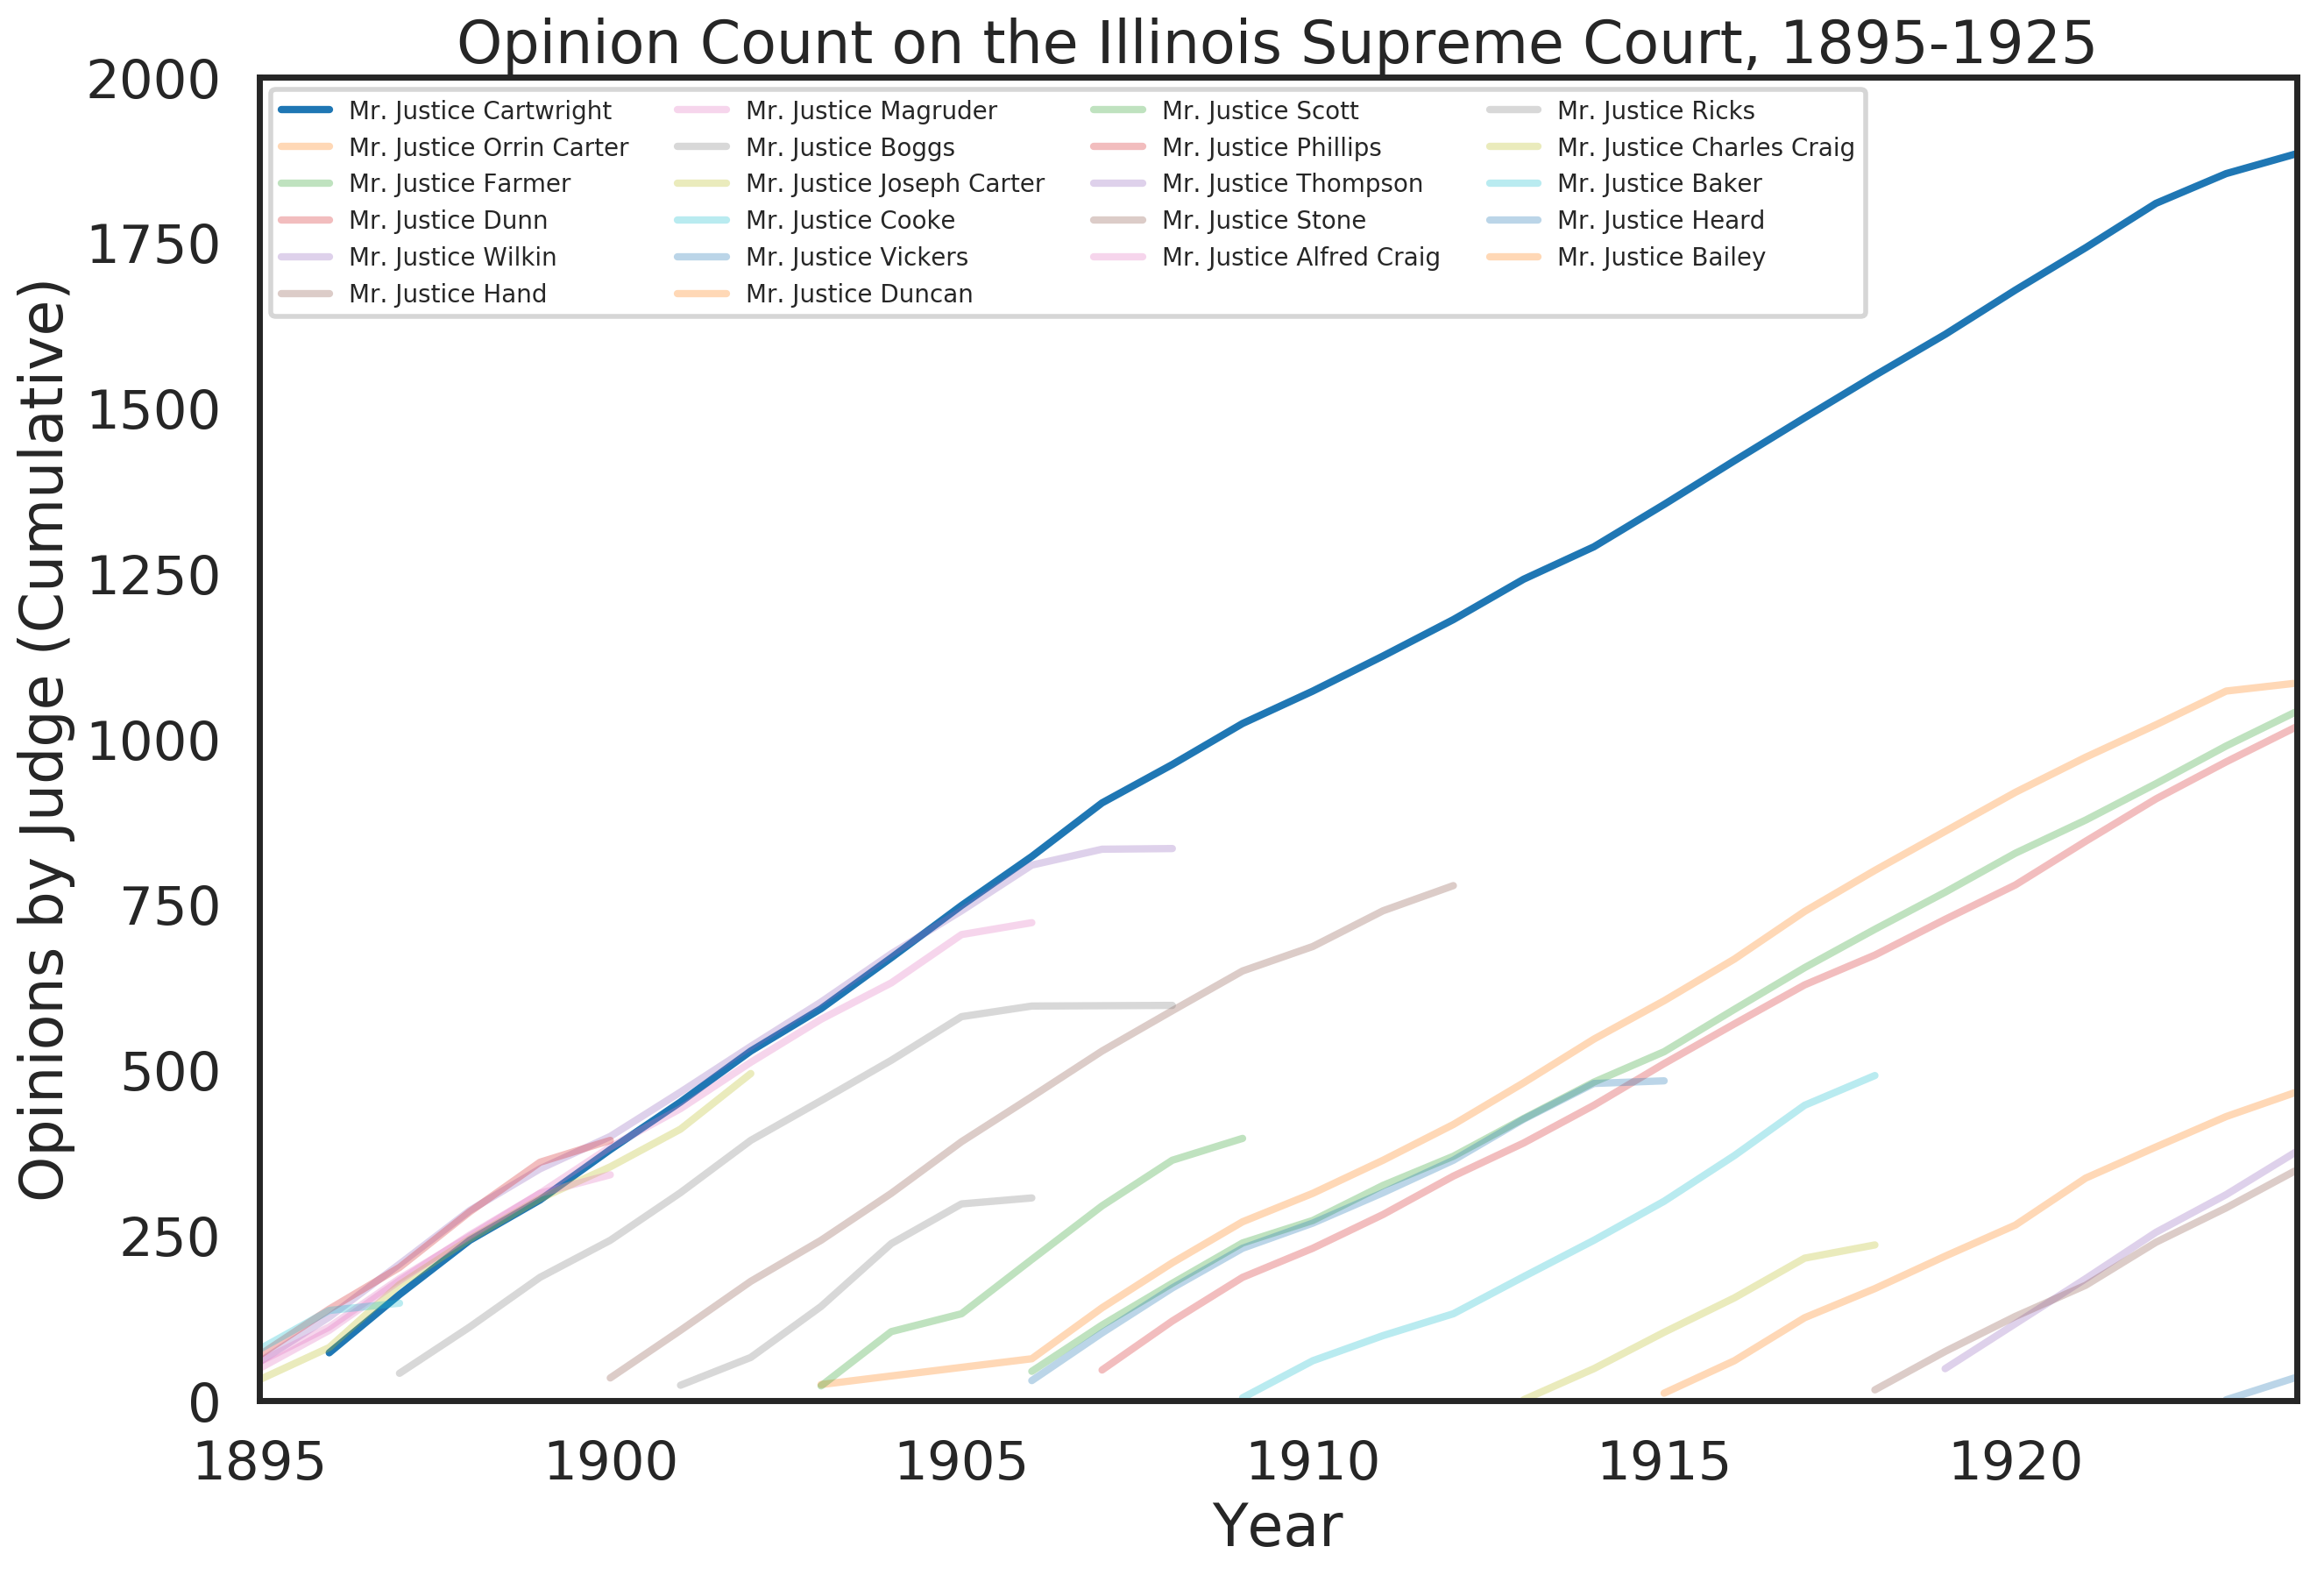

In [49]:
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 2000)
plt.xlim(1895, 1924)

#Calculate cumulative opinion count over timespan. 
#Note that this does not account for opinions written prior to 1895
for justice in justices:
    items = peers_df[peers_df["author"] == justice]["date"].apply(lambda x:x.year).value_counts().items()
    items = sorted(items, key=lambda x:x[0])
    x,y = zip(*items)
    x,y = list(x), list(y)
    for i in range(1, len(y)):
        y[i] = y[i] + y[i-1]
        i += 1
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.3
    plt.plot(x,y, alpha=alp, label=justice)


plt.title("Opinion Count on the Illinois Supreme Court, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge (Cumulative)")
plt.legend(ncol=4, fontsize=10)
plt.savefig("cartwright2.png")
plt.show()

Cartwright wrote cases at a formidible rate for a very long time. While his production was matched or outstripped by multiple other justices at different points throughout his career (particularly Justice Carter), nobody could touch his consistency throughout this 30-year period.

But how long were all these opinions? Let's generate some opinion length statistics for our justices.

In [50]:
prep_df_words = []
for justice in justices:
    just_df = peers_df[peers_df["author"] == justice]
    temp = {}
    temp["justice"] = justice
    temp["total_words"] = sum(just_df["text"].apply(lambda x: len(x.split(" "))))
    temp["opinions"] = len(just_df)
    temp["avg_words"] = temp["total_words"]/temp["opinions"]
    prep_df_words.append(temp)

display_word_results = pd.DataFrame(prep_df_words, columns=["justice", "opinions", "total_words", "avg_words"])

print("{:,} words across all justices".format(sum(display_word_results["total_words"])))
average_length = sum(display_word_results["total_words"])/sum(display_word_results["opinions"])
print("Average opinion length of {:,} words across all justices".format(round(average_length)))


display_word_results.sort_values('total_words', ascending=False).reset_index(drop=True)

23,871,907 words across all justices
Average opinion length of 1,909 words across all justices


,justice,opinions,total_words,avg_words
0,Mr. Justice Cartwright,1884,3186195,1691.186306
1,Mr. Justice Orrin Carter,1084,2354752,2172.280443
2,Mr. Justice Farmer,1041,2061113,1979.935639
3,Mr. Justice Magruder,722,1951520,2702.936288
4,Mr. Justice Dunn,1018,1768163,1736.898821
5,Mr. Justice Hand,778,1388244,1784.375321
6,Mr. Justice Wilkin,834,1202067,1441.327338
7,Mr. Justice Duncan,466,1190590,2554.914163
8,Mr. Justice Boggs,597,1128022,1889.484087
9,Mr. Justice Vickers,483,1016118,2103.763975


/Users/aaizman/.pyenv/versions/3.5.4/envs/capexamples/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


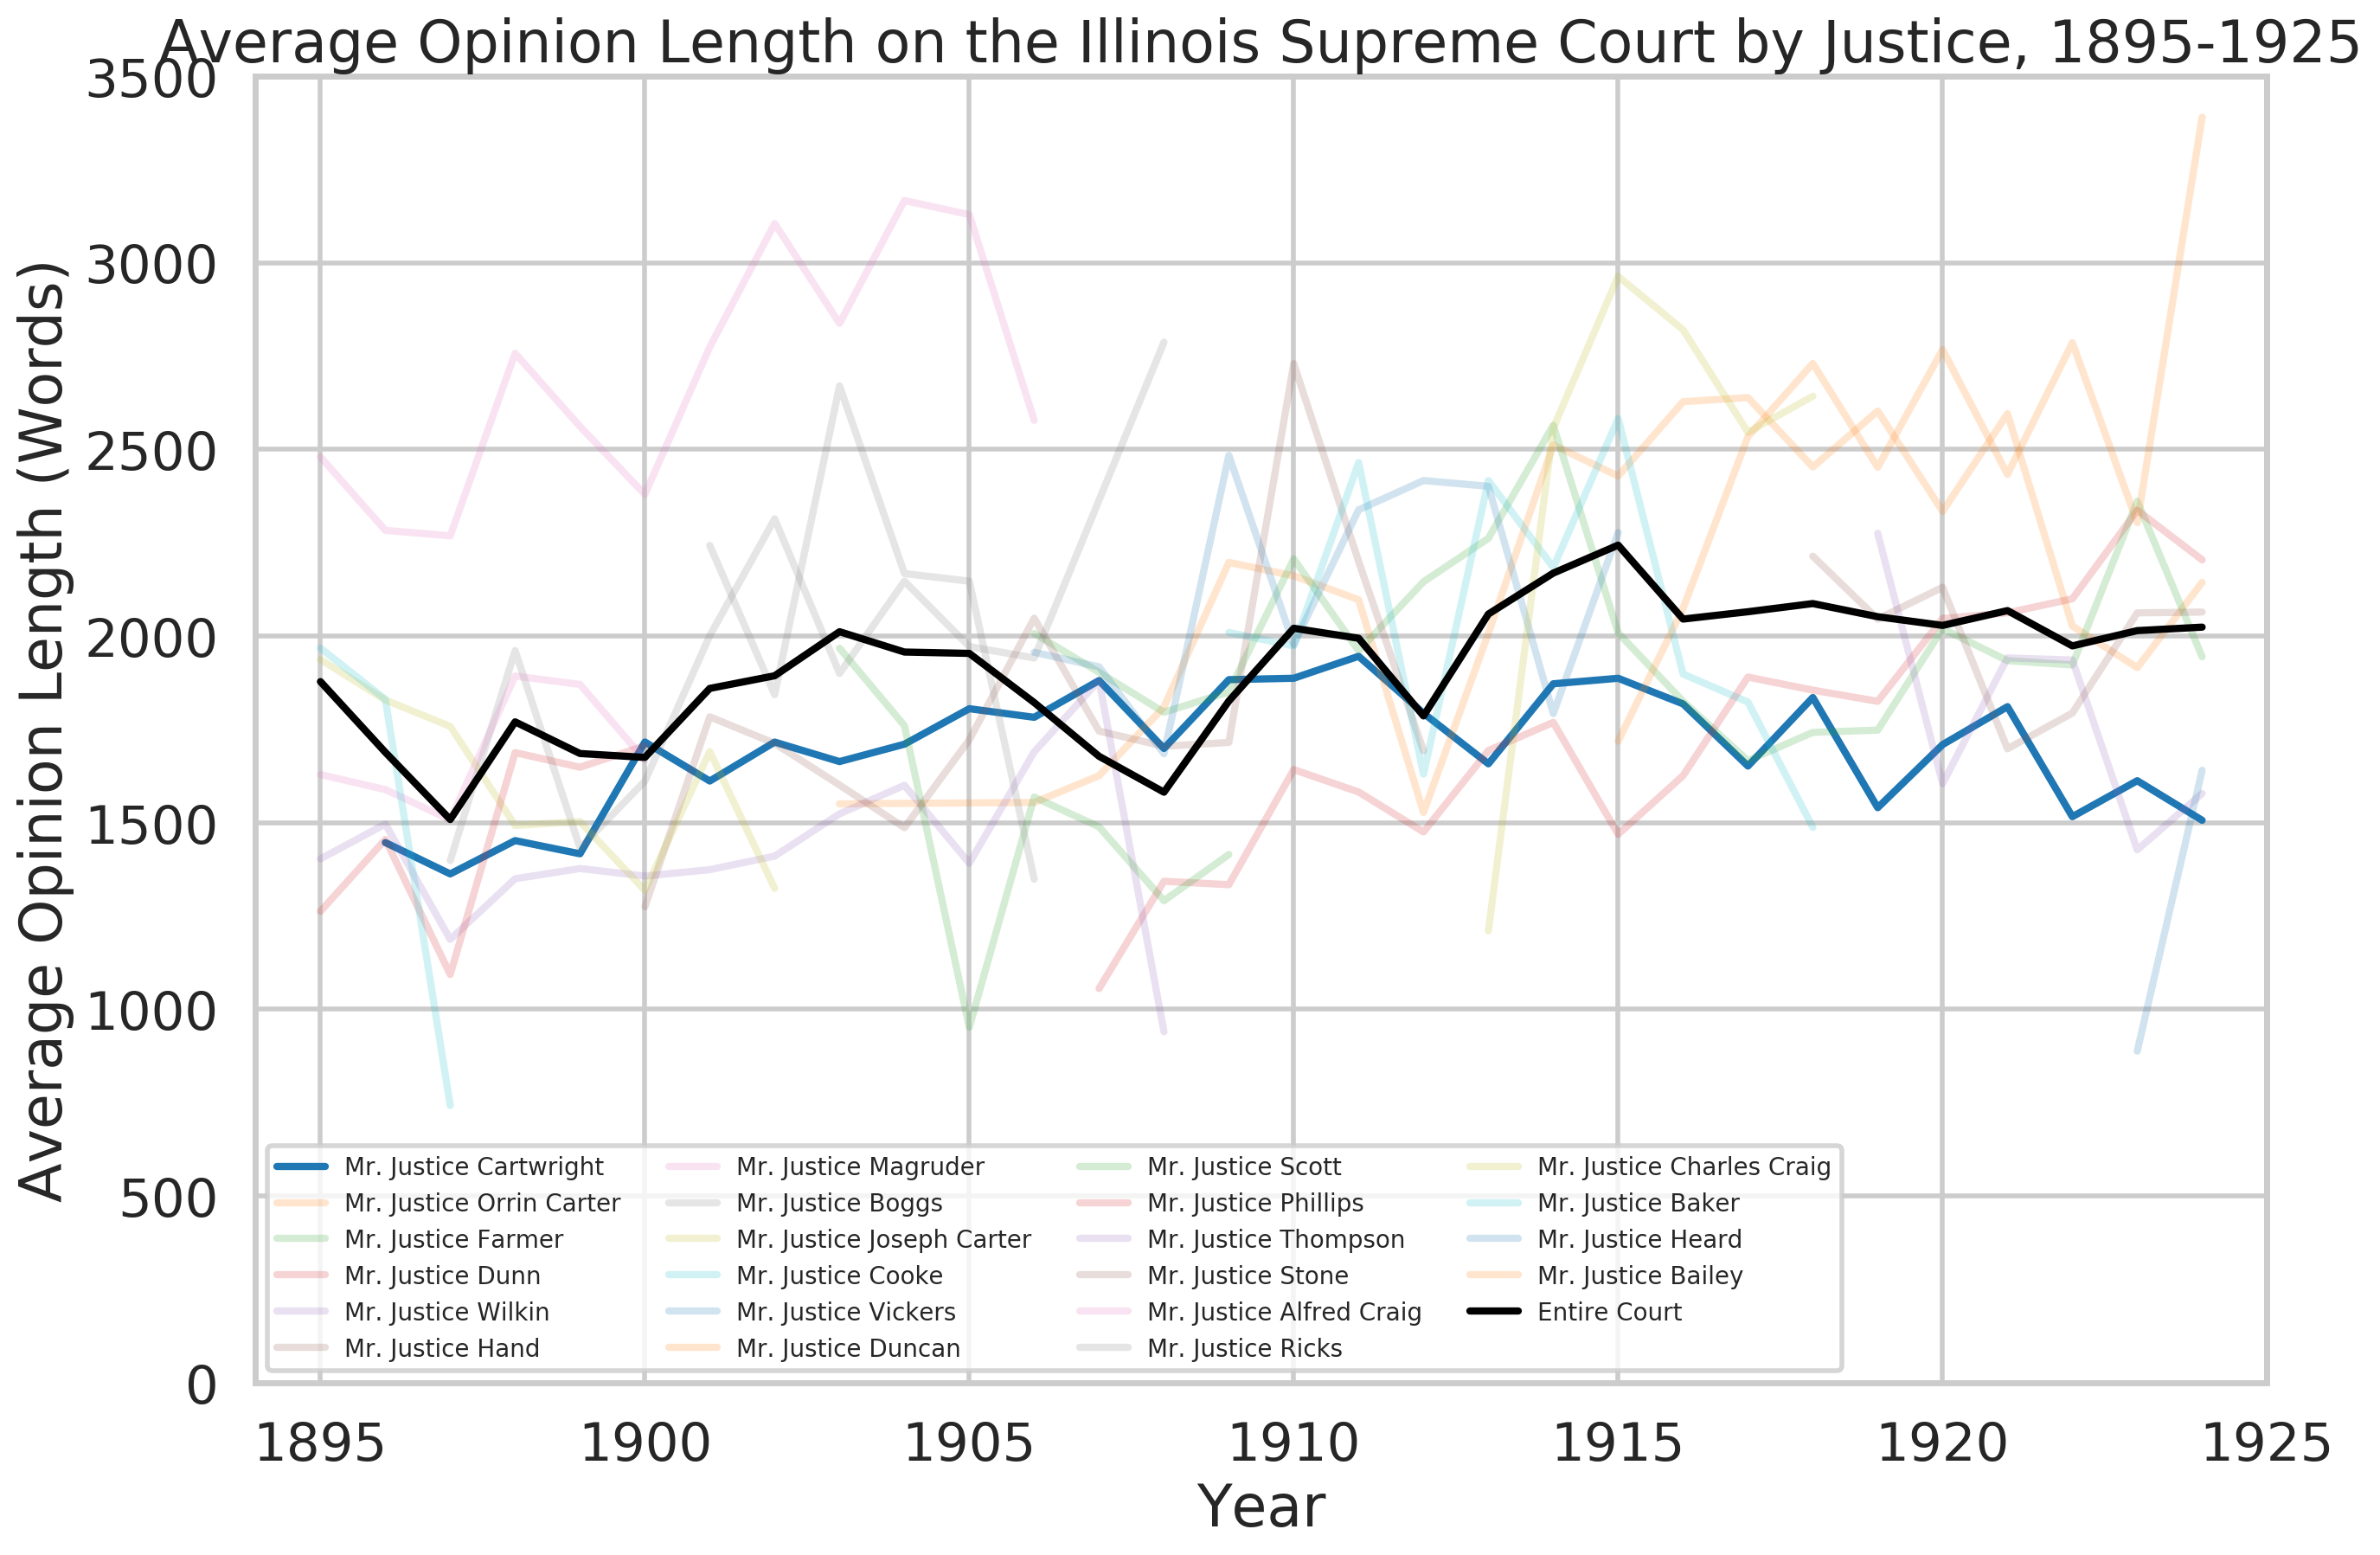

In [51]:
se.set_style('whitegrid')
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 3500)
plt.xlim(1894, 1925)

#plot average word count per year for each justice on the court
for justice in justices:
    temp_df = peers_df[peers_df["author"] == justice]
    temp_df["year"] = temp_df["date"].apply(lambda x:x.year)
    items = []
    for year in sorted(temp_df["year"].unique()):
        total_words = sum(temp_df[temp_df["year"] == year]["text"].apply(lambda x: len(x.split(" "))))
        avg_words = total_words/len(temp_df[temp_df["year"] == year])
        items.append((year, avg_words))
    x,y = zip(*items)
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.2
    plt.plot(x,y, alpha=alp, label=justice)

#run one more plot for the whole court
temp_df = peers_df
temp_df["year"] = temp_df["date"].apply(lambda x:x.year)
items = []
for year in sorted(temp_df["year"].unique()):
    total_words = sum(temp_df[temp_df["year"] == year]["text"].apply(lambda x: len(x.split(" "))))
    avg_words = total_words/len(temp_df[temp_df["year"] == year])
    items.append((year, avg_words))
x,y = zip(*items)
plt.plot(x,y, alpha=1.0, color='black', label="Entire Court")

plt.title("Average Opinion Length on the Illinois Supreme Court by Justice, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Average Opinion Length (Words)")
plt.legend(ncol=4, fontsize=10, frameon=True)
plt.savefig("cartwright3.png")
plt.show()

Cartwright wrote more words than any other justice across this period in the court's history, but his opinions did tend to be on the shorter side. There's an exception to every rule, of course...

In [52]:
peers_df["op_length"] = peers_df["text"].apply(lambda x: len(x.split(" ")))
peers_df[peers_df["author"] == "Mr. Justice Cartwright"].sort_values("op_length")[-1:]

,author,citation,court,date,jurisdiction,name,text,type,year,op_length
31614,Mr. Justice Cartwright,"{'cite': '186 Ill. 510', 'type': 'official'}",Illinois Supreme Court,1900-10-19,Illinois,Ill.,delivered the opinion of the court: Five eject...,majority,1900,8025


... for Cartwright, that would be his 8,025 word majority opionion in the 1900 case 'H. W. Lightcap v. Lydia Bradley.'

In [53]:
peers_df.sort_values("op_length")[-1:]

,author,citation,court,date,jurisdiction,name,text,type,year,op_length
65777,Mr. Justice Duncan,"{'cite': '312 Ill. 396', 'type': 'official'}",Illinois Supreme Court,1924-04-14,Illinois,Ill.,delivered the opinion of the court: Some of th...,majority,1924,42735


That case, however, pales in comparison to the court's longest opinion in this period of its history, Justice Duncan's gargantuan 42,735 word majority opinion in 1924's 'The Chicago Title and Trust Company, Receiver, Appellant, vs. The Central Trust Company of Illinois, Appellee; The Chicago Title and Trust Company, Appellee, vs. The Central Trust Company of Illinois, Appellant'